In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copy, move
from glob import glob as g
from tqdm.notebook import tqdm

In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/content/cats-and-dogs.zip"

!unzip -xq '/content/cats-and-dogs.zip' #Linux Command

count = 0
for name in tqdm(g('/content/PetImages/*/*')):
  
  if not os.path.getsize(name):
    count += 1
    os.remove(name)
print(count, ' empty files removed')

--2021-04-02 11:00:53--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.33.180.114, 2600:1408:24:286::e59, 2600:1408:24:28b::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.33.180.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/content/cats-and-dogs.zip’

/content/cats-and-d 100%[===================>] 786.68M   101MB/s    in 8.3s    

2021-04-02 11:01:01 (94.5 MB/s) - ‘/content/cats-and-dogs.zip’ saved [824894548/824894548]




2  empty files removed


In [3]:
names = os.listdir('/content/PetImages/Cat')
print(len(names))
print(names[:5])

12500
['11440.jpg', '5578.jpg', '7373.jpg', '1472.jpg', '5353.jpg']


In [4]:
names = os.listdir('/content/PetImages/Dog')
print(len(names))
print(names[:5])

12500
['11440.jpg', '5578.jpg', '7373.jpg', '1472.jpg', '5353.jpg']


In [5]:
g('/content/PetImages/Cat/*jpg')

['/content/PetImages/Cat/11440.jpg',
 '/content/PetImages/Cat/5578.jpg',
 '/content/PetImages/Cat/7373.jpg',
 '/content/PetImages/Cat/1472.jpg',
 '/content/PetImages/Cat/5353.jpg',
 '/content/PetImages/Cat/2112.jpg',
 '/content/PetImages/Cat/10692.jpg',
 '/content/PetImages/Cat/2613.jpg',
 '/content/PetImages/Cat/6788.jpg',
 '/content/PetImages/Cat/9418.jpg',
 '/content/PetImages/Cat/6770.jpg',
 '/content/PetImages/Cat/8394.jpg',
 '/content/PetImages/Cat/10110.jpg',
 '/content/PetImages/Cat/8515.jpg',
 '/content/PetImages/Cat/11803.jpg',
 '/content/PetImages/Cat/9628.jpg',
 '/content/PetImages/Cat/11202.jpg',
 '/content/PetImages/Cat/5275.jpg',
 '/content/PetImages/Cat/12464.jpg',
 '/content/PetImages/Cat/4862.jpg',
 '/content/PetImages/Cat/7262.jpg',
 '/content/PetImages/Cat/11068.jpg',
 '/content/PetImages/Cat/10583.jpg',
 '/content/PetImages/Cat/1152.jpg',
 '/content/PetImages/Cat/2393.jpg',
 '/content/PetImages/Cat/2017.jpg',
 '/content/PetImages/Cat/2875.jpg',
 '/content/PetImages

In [6]:
train_cats_dir = '/content/cats-v-dogs/training/cats'
train_dogs_dir = '/content/cats-v-dogs/training/dogs'
test_cats_dir = '/content/cats-v-dogs/testing/cats'
test_dogs_dir = '/content/cats-v-dogs/testing/dogs'
to_create = [
            train_cats_dir,
            train_dogs_dir,
            test_cats_dir,
            test_dogs_dir
]

for element in to_create:
  parent_dir = element
  path = os.path.join(parent_dir)
  os.makedirs(path, exist_ok = True)

In [7]:
all_cats = sorted(g('/content/PetImages/Cat/*jpg'))
all_dogs = sorted(g('/content/PetImages/Dog/*jpg'))

In [8]:
from sklearn.model_selection import train_test_split
dogs_train, dogs_test = train_test_split(all_dogs, test_size = 0.1, random_state = 101, shuffle = True)

In [9]:
cats_train, cats_test = train_test_split(all_cats, test_size = 0.1, random_state = 101, shuffle = True)

In [10]:
for name in tqdm(dogs_train):
  copy(name , os.path.join(train_dogs_dir , name.split('/')[-1]))
for name in tqdm(cats_train):
  copy(name , os.path.join(train_cats_dir , name.split('/')[-1]))
  
for name in tqdm(dogs_test):
  copy(name , os.path.join(test_dogs_dir , name.split('/')[-1]))
for name in tqdm(cats_test):
  copy(name , os.path.join(test_cats_dir , name.split('/')[-1]))

In [11]:
print(len(os.listdir(train_dogs_dir)))
print(len(os.listdir(train_cats_dir)))
print(len(os.listdir(test_cats_dir)))
print(len(os.listdir(test_dogs_dir)))

11249
11249
1250
1250


In [12]:
TRAINING_DIR = '/content/cats-v-dogs/training'
train_datagen = ImageDataGenerator(rescale=1 / 255)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=64,
    class_mode='binary',
    target_size=(150, 150)
)

VALIDATION_DIR = '/content/cats-v-dogs/testing'
validation_datagen = ImageDataGenerator(rescale=1 / 255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=64,
    class_mode='binary',
    target_size=(150, 150)
)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [13]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = (150,150,3), padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(units = 1, activation = 'sigmoid'))

In [14]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

In [15]:
print('Num Params : ', model.count_params())
history = model.fit(
    train_generator,
    epochs=40,
    verbose=1,
    validation_data=validation_generator
)

Num Params :  1438017
Epoch 1/40
338/352 [===========================>..] - ETA: 2s - loss: 0.7092 - accuracy: 0.5183

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

352/352 [==============================] - 108s 213ms/step - loss: 0.7079 - accuracy: 0.5198 - val_loss: 0.6116 - val_accuracy: 0.6540
Epoch 2/40
352/352 [==============================] - 74s 212ms/step - loss: 0.6008 - accuracy: 0.6617 - val_loss: 0.5253 - val_accuracy: 0.7268
Epoch 3/40
352/352 [==============================] - 75s 212ms/step - loss: 0.5156 - accuracy: 0.7434 - val_loss: 0.4132 - val_accuracy: 0.8072
Epoch 4/40
352/352 [==============================] - 74s 211ms/step - loss: 0.4286 - accuracy: 0.8000 - val_loss: 0.4803 - val_accuracy: 0.7484
Epoch 5/40
352/352 [==============================] - 74s 211ms/step - loss: 0.3685 - accuracy: 0.8339 - val_loss: 0.2850 - val_accuracy: 0.8692
Epoch 6/40
352/352 [==============================] - 75s 212ms/step - loss: 0.3049 - accuracy: 0.8693 - val_loss: 0.2496 - val_accuracy: 0.8972
Epoch 7/40
352/352 [==============================] - 74s 211ms/step - loss: 0.2686 - accuracy: 0.8875 - val_loss: 0.2389 - val_accuracy: 0.

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       7

Text(0.5, 1.0, 'Training and validation loss')

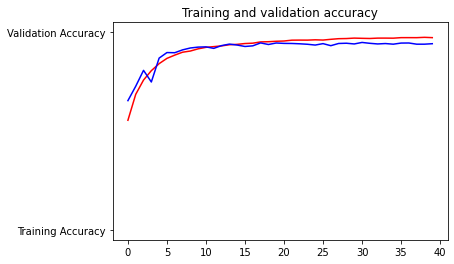

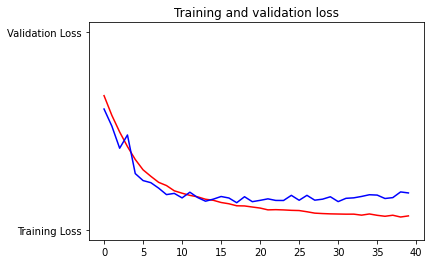

In [17]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [20]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
    # predicting images
    path = '/content/' + fn
    img = image.load_img(path, target_size=(150,150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.
    classes = model.predict(x, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(fn + " is a dog")
    else:
        print(fn + " is a cat")

Saving 10759.jpg to 10759.jpg
[0.9521823]
10759.jpg is a dog
